In [1]:
from fbprophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Importing plotly failed. Interactive plots will not work.


In [2]:
data = pd.read_csv('./train.csv')
data.head().append(data.tail())

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580
18287,18287,25-09-2014 23:00,534


In [3]:
# 数据预处理
data_prophet = data.copy()
data_prophet['Datetime'] = pd.to_datetime(data_prophet['Datetime'], format='%d-%m-%Y %H:%M')
data_prophet.rename(columns={'Datetime': 'ds', 'Count': 'y'}, inplace=True)
data_prophet.drop('ID', axis=1, inplace=True)
data_prophet.index = data_prophet['ds']
data_prophet = data_prophet.resample('D').sum()
data_prophet['ds'] = data_prophet.index
data_prophet.head().append(data_prophet.tail())

,y,ds
ds,,
2012-08-25,76,2012-08-25
2012-08-26,88,2012-08-26
2012-08-27,62,2012-08-27
2012-08-28,58,2012-08-28
2012-08-29,60,2012-08-29
2014-09-21,9102,2014-09-21
2014-09-22,14116,2014-09-22
2014-09-23,13304,2014-09-23
2014-09-24,16856,2014-09-24


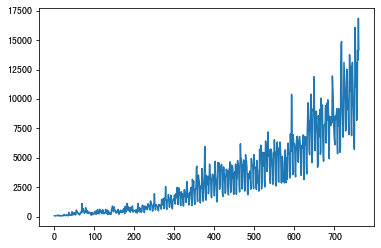

In [4]:
# 原数据可视化
plt.plot(data_prophet['y'].values)
plt.show()

原曲线看上像线性，不像log函数，趋势预测的模型选择'linear'可能更为合适

In [5]:
# 增加 holiday
date_day = np.concatenate((pd.date_range('2012-10-1', '2012-10-7', freq='D').values, pd.date_range('2013-10-1', '2013-10-7', freq='D').values), axis=0)
national_day = pd.DataFrame({
    'holiday': 'national',
    'ds': date_day,
    'lower_window': -2,
    'upper_window': 2,
})

date_day = np.concatenate((pd.date_range('2013-5-1', '2013-5-3', freq='D').values, pd.date_range('2014-5-1', '2014-5-3', freq='D').values), axis=0)
labour_day = pd.DataFrame({
    'holiday': 'labour_day',
    'ds': date_day,
    'lower_window': -1,
    'upper_window': 1,
})

holiday = pd.concat([national_day, labour_day], axis=0)
holiday.head().append(holiday.tail())
                           

,holiday,ds,lower_window,upper_window
0,national,2012-10-01,-2,2
1,national,2012-10-02,-2,2
2,national,2012-10-03,-2,2
3,national,2012-10-04,-2,2
4,national,2012-10-05,-2,2
1,labour_day,2013-05-02,-1,1
2,labour_day,2013-05-03,-1,1
3,labour_day,2014-05-01,-1,1
4,labour_day,2014-05-02,-1,1
5,labour_day,2014-05-03,-1,1


In [6]:
model = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.98,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=holiday,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.6,
    uncertainty_samples=1000,
    stan_backend=None,
)

# 增加一个月的周期
model.add_seasonality(name='monthly', period=30, fourier_order=3)

# 拟合数据
model.fit(data_prophet)
future = model.make_future_dataframe(periods=210)
result = model.predict(future)

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


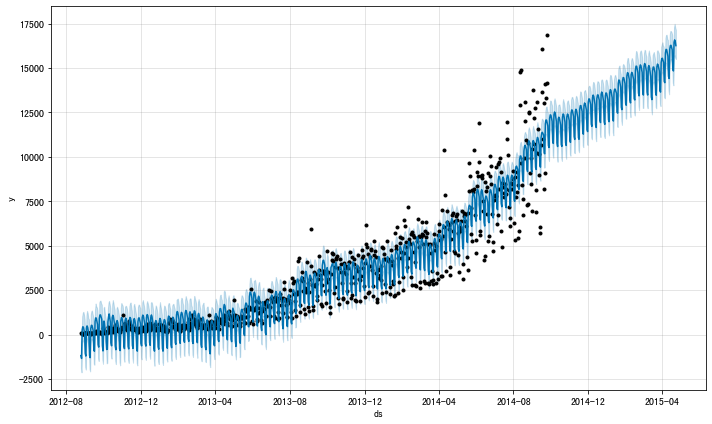

In [7]:
model.plot(result)
plt.show()

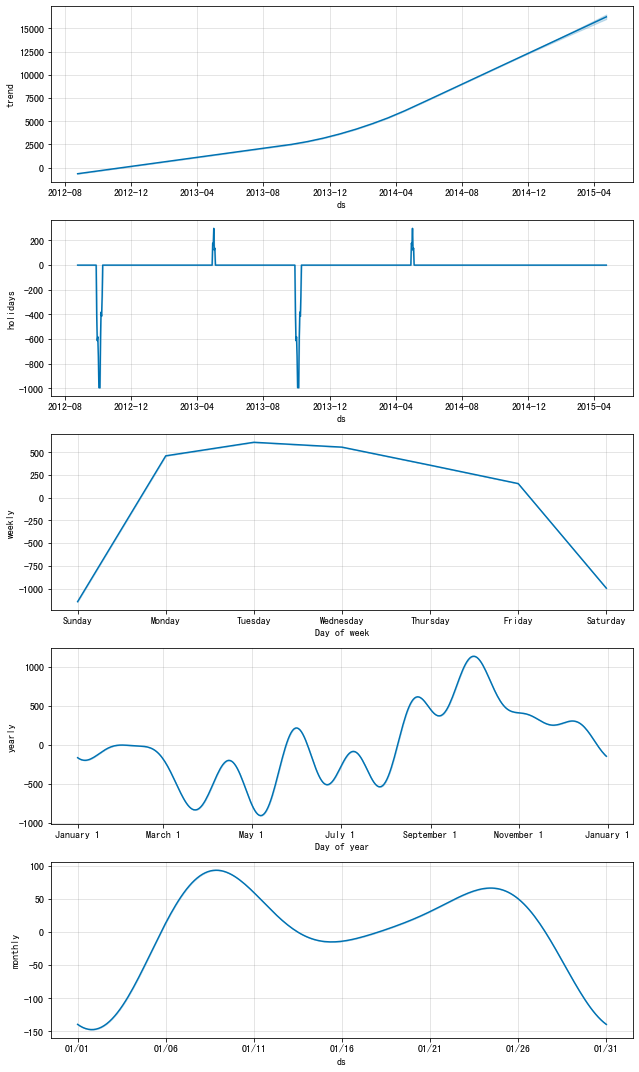

In [8]:
model.plot_components(result)
plt.show()

1. 整体来看：交通流量是不断的提高
2. 从节日看：国庆节是负效应，五一劳动节是正效应
3. 从星期看：工作日主要是交通流量的贡献者
4. 从年度看：高峰几种在9月到11月之间，低谷在3-4月份
5. 从月度看：中上旬和中下询的交通流量比较集中

In [9]:
result[(result['national']+result['labour_day']) != 0][['ds', 'national', 'labour_day']]

,ds,national,labour_day
35,2012-09-29,-407.973596,0.000000
36,2012-09-30,-612.364470,0.000000
37,2012-10-01,-581.168238,0.000000
38,2012-10-02,-737.212321,0.000000
39,2012-10-03,-993.824049,0.000000
40,2012-10-04,-993.824049,0.000000
41,2012-10-05,-993.824049,0.000000
42,2012-10-06,-585.850453,0.000000
43,2012-10-07,-381.459578,0.000000
44,2012-10-08,-412.655811,0.000000
